In [383]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import optuna
import math

"Сырые" данные о квартирах хранятся в базе данных. Для их получения необходимо установить соединение с ней.

In [362]:
# database connection

conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

Загружаем данные из базы данных.

In [363]:
# getting data

df = pd.read_sql_query('select * from flats_new', conn)

C:\Users\eliza\AppData\Local\Temp\ipykernel_28636\3829361265.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('select * from flats_new', conn)


Осуществляем общую предобработку данных. В предварительную предобработку вошли следующие составляющие:
1. Приведение информации о расстоянии до метро, цене, площади квартиры, количестве туалетов, лифтов, балконах и лоджиях в корректный формат для дальнейшей работы;
2. Удаление колонок, состоящих по большей части из пропущенных значений (warning, trash, barriers), не несущих какой-либо важной информации (id), содержащих большое количество пропущенных значений (decor, year) или одинаковые для всех наблюдений значения (rented).
3. Удаление дупликатов.
4. Заполнение пропусков. Пропуски в колонках с численными значениями были заполнены средним или средним по группе (расстояние до метро в минутах), для категориальных признаков использовалась мода.
5. Удаление наблюдений, в которых отсутствовала информация об общей жилой площади, жилой площади и площади кухни.
6. Удаление наблюдений с некорректным названием района.

In [364]:
# general preproccessing

df['metro'] = df['metro'].apply(metro_distance)
df['price'] = df['price'].apply(price_corr)
df.drop(['id', 'warning', 'trash', 'barriers'], inplace=True, axis=1)
df.drop_duplicates(inplace=True)

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)

df['district'] = df['address'].apply(lambda x: x.split()[4] if len(x) >=4 else x)
df = df.replace('None', np.nan)
df.drop('address', inplace=True, axis=1)

df['toilets'].fillna(df['toilets'].mode()[0], inplace=True)
df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)
df['big_elevs'] = df['elevators'].apply(big_elevators)
df['little_elevs'] = df['elevators'].apply(lit_elevators)
df['single_toilet'] = df['toilets'].apply(toilet_single)
df['connect_toilet'] = df['toilets'].apply(toilet_not_sngl)
df['balcony_only'] = df['balcony'].apply(balcony)
df['lodgia'] = df['balcony'].apply(lodgia)

df = df[df['district'].isin(['Советский', 'Центральный', 'Октябрьский', 'Кировский', \
                              'Ленинский', 'Заельцовский', 'Железнодорожный', 'Первомайский', 'Дзержинский', 'Калининский'])]

In [365]:
df.drop(['decor', 'year', 'rented', 'balcony', 'elevators', 'toilets'], axis=1, inplace=True)


df['ceil_height'].fillna(df['ceil_height'].mode()[0], inplace=True)

df['ceil_height'] = df['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df['warm'] = df['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df['window_view'].fillna(df['window_view'].mode()[0], inplace=True)
df = df.dropna(subset=['kitchen_sq', 'total_square', 'living_sq'])
cat_features = ['home_type', 'warm', 'district', 'window_view']

df['single_toilet'] = df['single_toilet'].apply(lambda x: x if x != 'None' else 0)
df['connect_toilet'] = df['connect_toilet'].apply(lambda x: x if x != 'None' else 0)

df['metro'].fillna(round(df.groupby('district')['metro'].transform('mean')), inplace=True)

df['entrance'].fillna(round(df['entrance'].mode()[0]), inplace=True)

Так как такие модели как линейная регрессия и случайный лес не могут работать с категориальными признаками, необходимо сформировать датафррейм, в котором категориальные переменные будут преобразованы в dummy переменные. По сути, это то же самое, что и кодирование с помощью One-Hot Encoder. Укажем, что drop_first = True во избежание возникновения мультиколлинеарности.

In [366]:
df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64', drop_first=True)

Проведем EDA (exploratory data analysis). Для начала, построим точечные графики, которые помогут нам пронаблюдать зависимость цены квартир от различных значимых, на мой взгляд, параметров. В качестве таких параметров я выбрал общую площадь, жилую площадь, площадь кухни и высоту потолков. Можем видеть, что присутствует сильная положительная корреляция между площадью и ценой на квартиру. Корреляция между высотой потолков и ценой квартиры очень мала, на первый взгляд. Заметны сильные выбросы в данных. Ими нужно будет заняться.

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

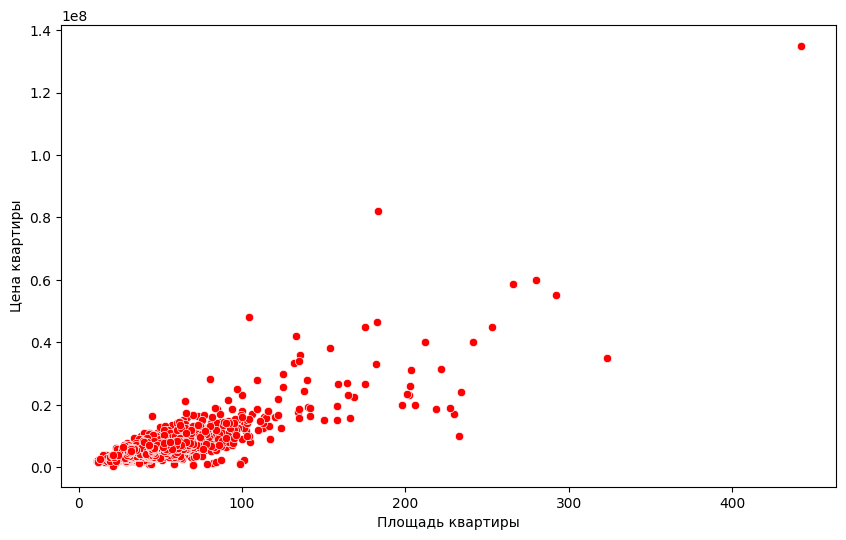

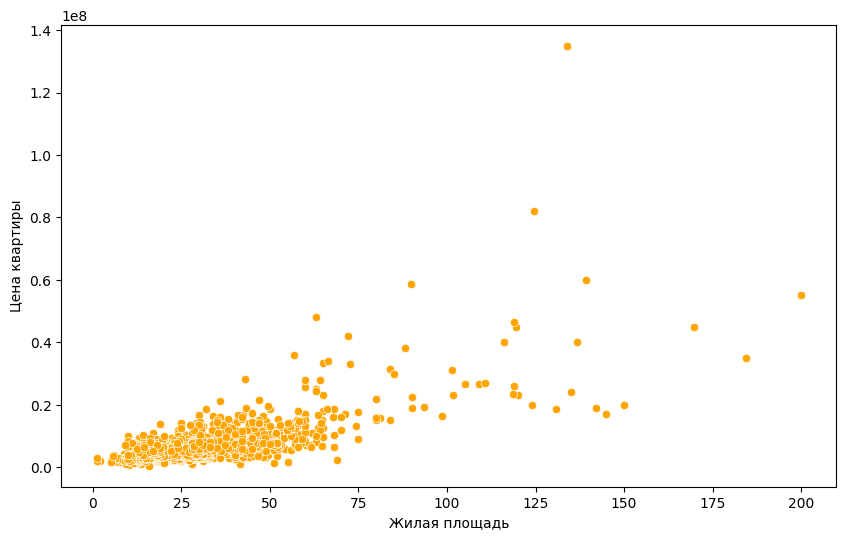

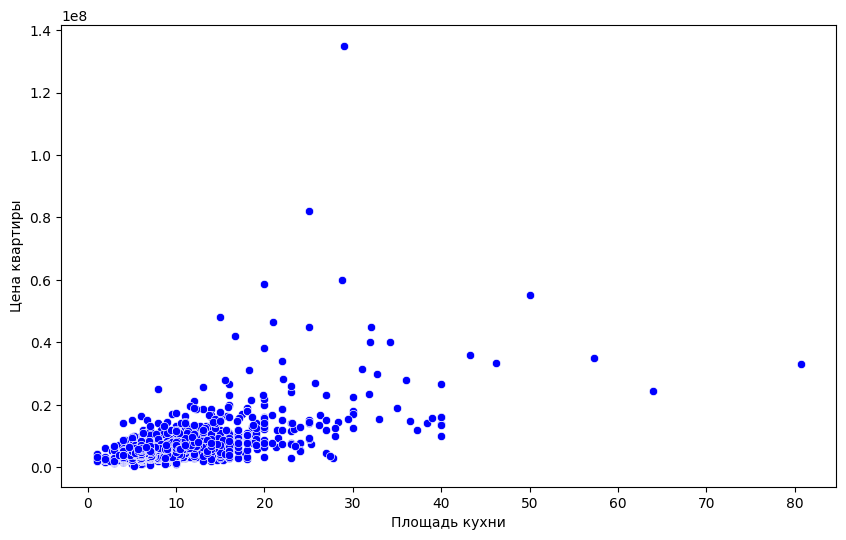

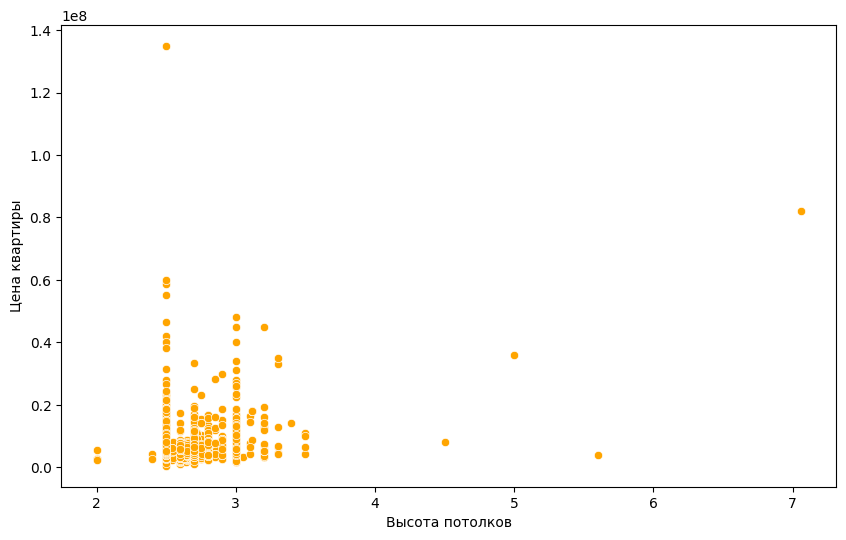

In [367]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['ceil_height'], y=df['price'], color='orange')

Теперь взглянем на распределение цен квартир. Для иллюстрации распределения я использовал гистограмму, добавил ядерную оценку плотности. В результате мы можем видеть тяжелый правый хвост и ассимметрию.

<Axes: title={'center': 'Гистограмма цен на квартиры'}, xlabel='Цена квартиры', ylabel='Количество квартир'>

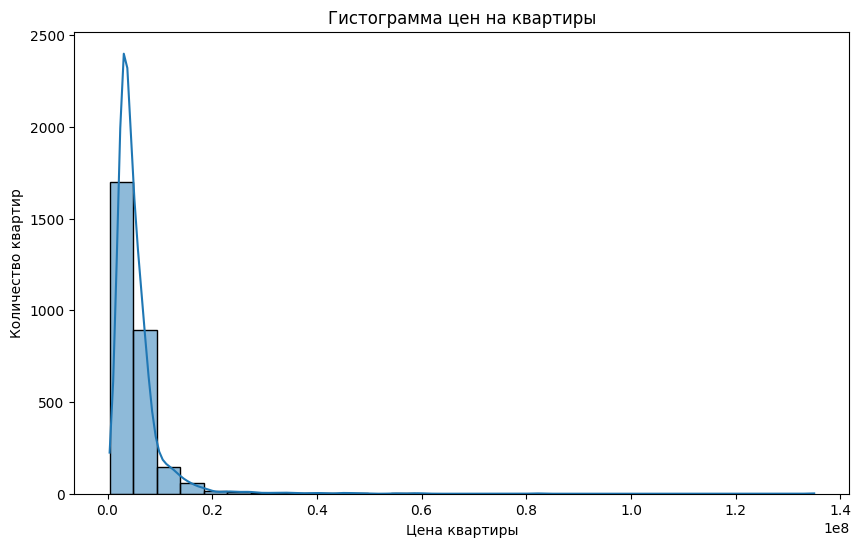

In [369]:
plt.figure(figsize=(10, 6))
plt.xlabel('Цена квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма цен на квартиры')
sns.histplot(df['price'], bins=30, kde=True)

Посмотрим на распределение логарифма цен на квартиры. Оно уже больше напоминает нормальное.

<Axes: title={'center': 'Гистограмма логарифмированных цен на квартиры'}, xlabel='Логарифм цены квартиры', ylabel='Количество квартир'>

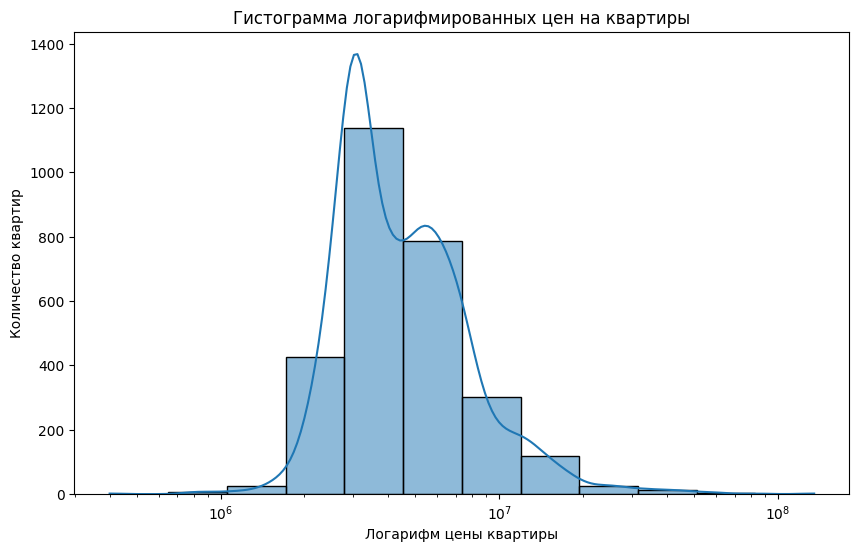

In [370]:
plt.figure(figsize=(10, 6))
plt.xlabel('Логарифм цены квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма логарифмированных цен на квартиры')
sns.histplot(df['price'], bins=(round(1 + 3.322*math.log(len(df), 10))), log_scale=True, kde=True)

Теперь посмотрим на гистограмму площадей квартир. Виден тяжелый правый хвост и ассимметрия. Однако уже можно сказать, что у большей части квартир площадь не превышает 100 квадратных метров.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

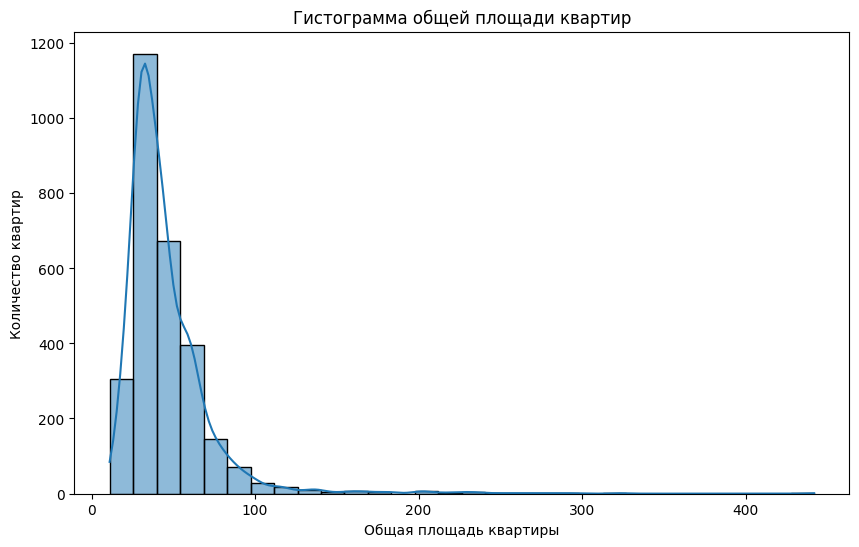

In [371]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

Взглянем на то, как распределено расстояние от квартир до метро в минутах. Большая часть квартир находится примерно в 15 минутах от метро.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Количество квартир'>

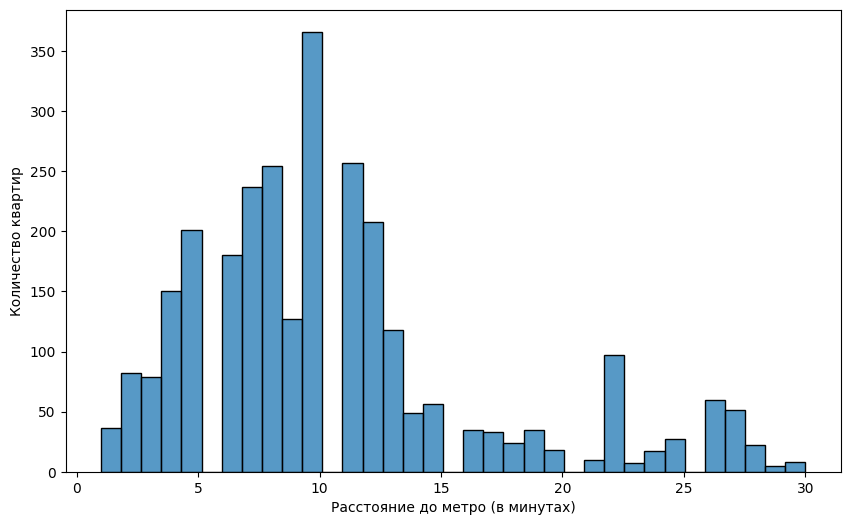

In [372]:
plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Количество квартир')
sns.histplot(df['metro'])

In [346]:
df['metro'].describe()

count    2553.000000
mean       10.785742
std         6.176791
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        30.000000
Name: metro, dtype: float64

Посмотрим на общее соотношение районов в датафрейме. Как можно видеть, меньше всего квартир из Советского района, больше всего - из Ленинского и Кировского.

<Axes: xlabel='Район', ylabel='Количестов квартир'>

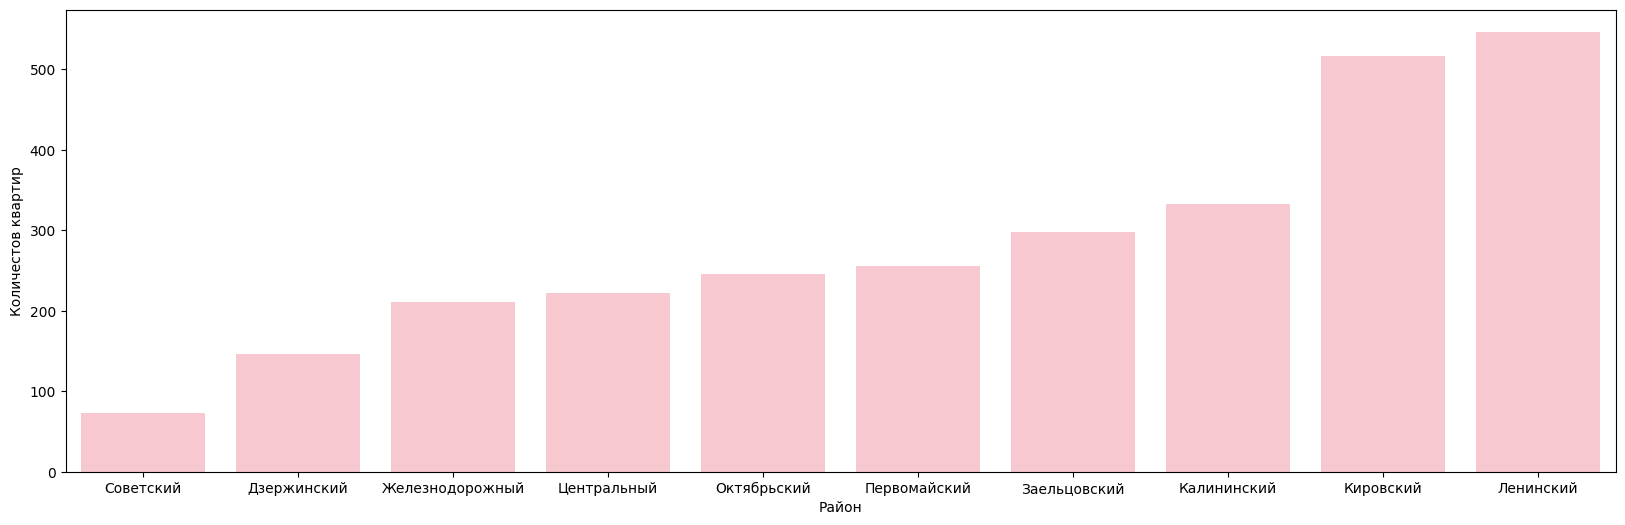

In [79]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df['district'].value_counts(ascending=True)
sns.barplot(districts, color='pink')

Пора разобраться с выбросами. Удалять выбросы будем с помощью межквартирльного размаха (IQR). 

In [374]:
# outliers (old flats)

for column in['total_square', 'ceil_height', 'kitchen_sq']:
    q1 = df_dummy[column].quantile(0.25)
    q3 = df_dummy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_dummy = df_dummy[df_dummy[column].between(lower_bound, upper_bound)]
    df = df[df[column].between(lower_bound, upper_bound)]
    

Посмотрим на то, как изменилась гистограмма площади квартир. Видно, что правый хвост стал менее тяжелым, нам удалось избавиться от самых явных выбросов.

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

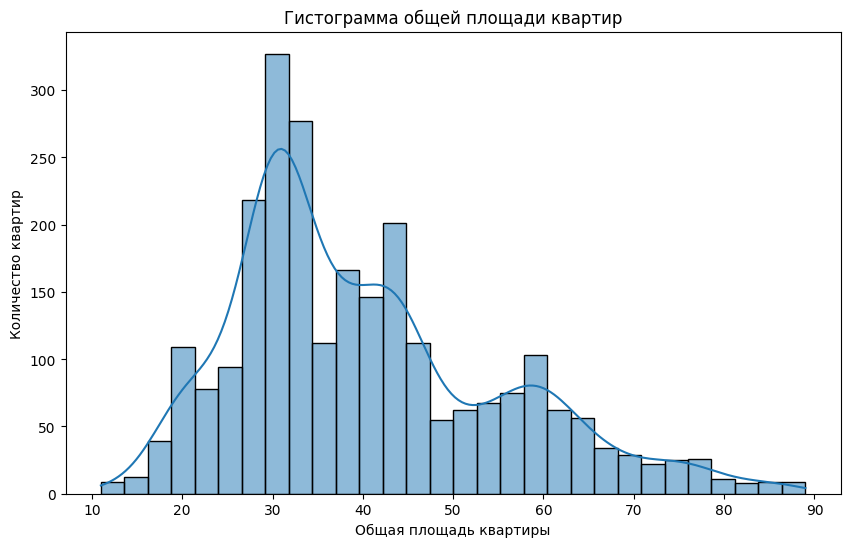

In [375]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=30, kde=True)

После удаления выбросов также будет полезно взглянуть на то, как изменился точечный график цены квартиры и ее общей площади, площади кухни, жилой площади. К тому же, я решил посмотреть, на то, как зависит цена квартиры от типа дома и расстояния до метро. Сделал это также с помощью точечных графиков. График с типом дома и его ценой оказался не особо информативным. График с метро показал, что все-таки квартиры, расположенные рядом с метро, наверное, стоят в среднем больше чем те, что находятся далеко от метро. Конечно, сказать что-то конкретное можно только после проведения статистических тестов.

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Цена квартиры'>

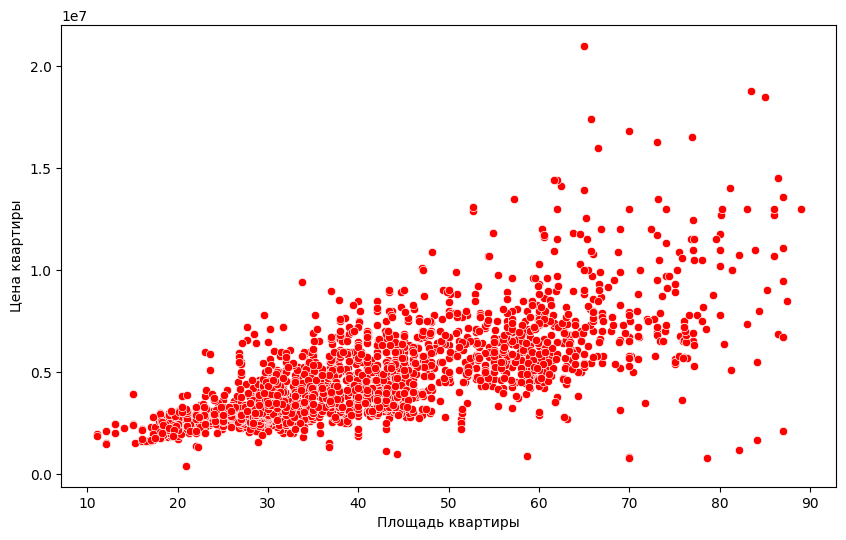

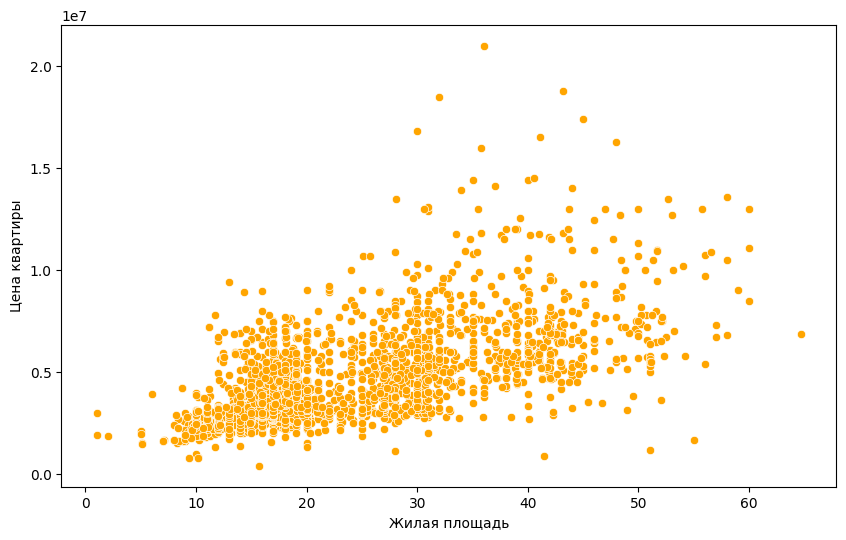

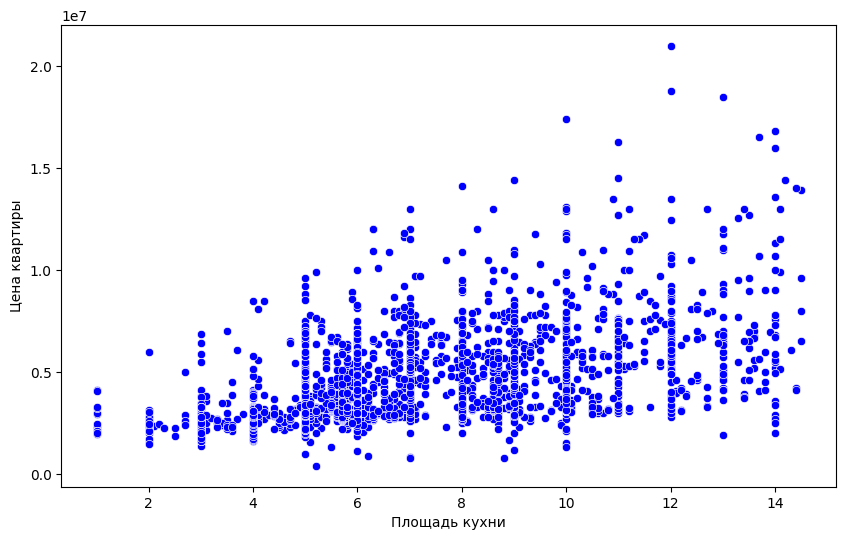

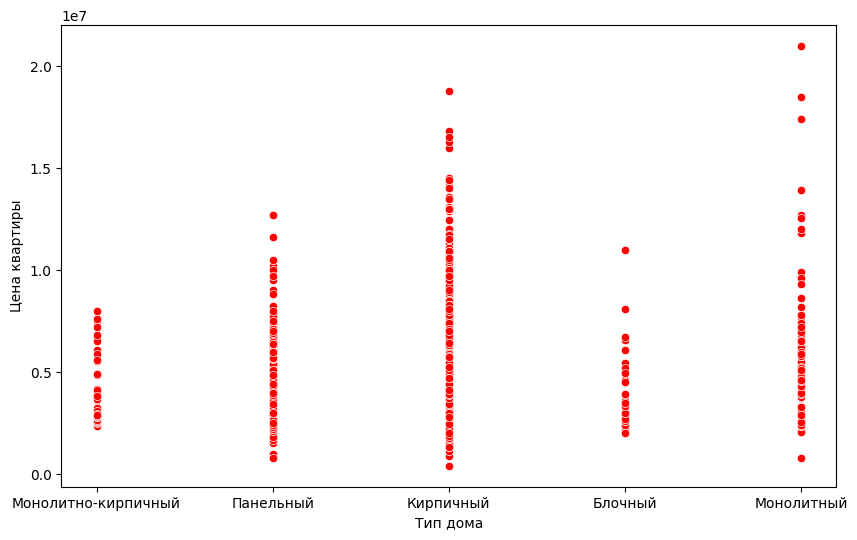

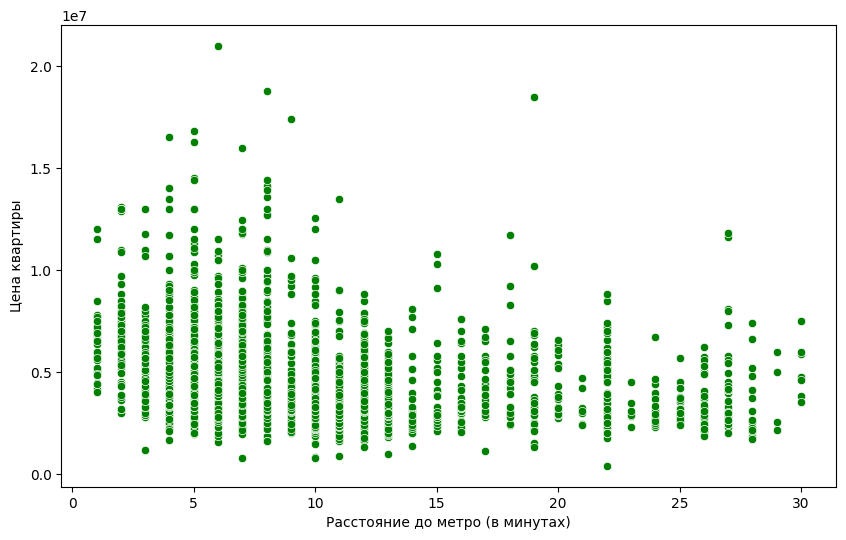

In [377]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))
plt.xlabel('Тип дома')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['home_type'], y=df['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['metro'], y=df['price'], color='green')

Теперь все-таки посмотрим на корреляционную матрицу числовых признаков. Можем видеть, что цена больше всего коррелирует с общей площадью, жилой площадью и площадью кухни.

<Axes: title={'center': 'Корреляционная матрица числовых признаков'}>

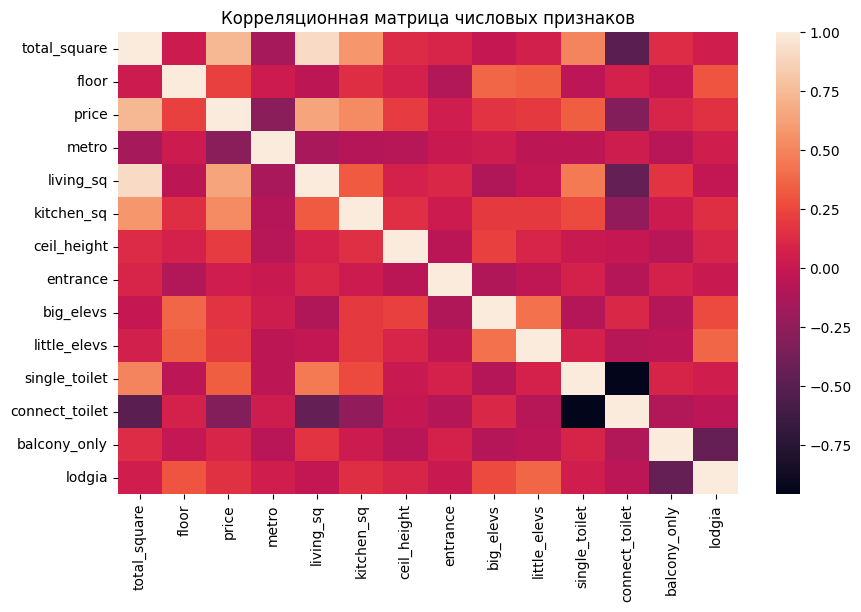

In [382]:
df_numeric = df.select_dtypes(['float64', 'int64'])
plt.figure(figsize=(10, 6))
plt.title('Корреляционная матрица числовых признаков')
sns.heatmap(df_numeric.corr())

Приступим к построению разлчиных моделей и сравнению их эффективности. Для начала разделим выборку на тренировочную и валидационную части. В силу небольшого объема данных, я не стал разделять выборку на тренировочную, тестовую и валидационную части. 

In [384]:
train, test = train_test_split(df_dummy, test_size=0.2, random_state=34)

x = train.drop(['price'], axis=1)
y = train['price']

Построим линейную регрессию методом наименьших квадратов. На каждой итерации будем удалять незначимый регрессор.

In [385]:
maxpvalue = 1
n = 1
regressors = train.drop('price', axis=1).columns.to_list()

while maxpvalue > 0.05:
    x = train[regressors]
    y = train['price']
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1.astype(float)).fit()
    pv = model.pvalues.to_list()
    maxpv = max(pv[1:])
    max_index = pv.index(maxpv)
    print('Номер интерации: '+ str(n))
    print('Регрессор с максимальным p-value: '+ str(regressors[max_index-1]) + ' P-value: '+ str(maxpv))
    print('-------------------------------------------------------------')

    if maxpv > 0.05:
        regressors.pop(max_index - 1)
        maxpvalue = maxpv
        n += 1
    else:
        maxpvalue = 0

print('Итоговая модель: ')
y = train['price']
x = train[regressors]
x1 = sm.add_constant(x)
model = sm.OLS(y, x1.astype(float)).fit()
print(model.summary2())

Номер интерации: 1
Регрессор с максимальным p-value: window_view_На улицу и двор P-value: 0.8888184376656598
-------------------------------------------------------------
Номер интерации: 2
Регрессор с максимальным p-value: home_type_Монолитно-кирпичный P-value: 0.6104035768061445
-------------------------------------------------------------
Номер интерации: 3
Регрессор с максимальным p-value: district_Октябрьский P-value: 0.30790641499085725
-------------------------------------------------------------
Номер интерации: 4
Регрессор с максимальным p-value: district_Советский P-value: 0.485799763805275
-------------------------------------------------------------
Номер интерации: 5
Регрессор с максимальным p-value: warm_Котел/Квартирное отопление P-value: 0.3237879305850738
-------------------------------------------------------------
Номер интерации: 6
Регрессор с максимальным p-value: entrance P-value: 0.26022146666887425
-------------------------------------------------------------
Но

Получили модель линейной регрессии. Удивительно, что, оказывается близость к метро, судя по коэффициенту, уменьшает стоимость квартиры. То, как влияет каждый регрессор на стоимость квартиры можно понять, исходя из коэффициента, стоящего перед этим регрессором.

In [386]:
print(model.summary2())

                                    Results: Ordinary least squares
Model:                          OLS                          Adj. R-squared:                 0.744     
Dependent Variable:             price                        AIC:                            62848.6394
Date:                           2024-05-05 13:43             BIC:                            62983.5598
No. Observations:               2042                         Log-Likelihood:                 -31400.   
Df Model:                       23                           F-statistic:                    258.2     
Df Residuals:                   2018                         Prob (F-statistic):             0.00      
R-squared:                      0.746                        Scale:                          1.3464e+12
-------------------------------------------------------------------------------------------------------
                                       Coef.       Std.Err.     t    P>|t|      [0.025        0.975]

Провалидируем нашу модель на тестовом наборе данных.

In [387]:
test_1 = test[model.params.index.to_list()[1:]]
test_1 = sm.add_constant(test_1)
pred = model.predict(test_1)

Можем видеть, что средняя абсолютная ошибка равна 778 тысяч рублей, то есть в среднем модель ошибается на 778 тысяч в определении стоимости квартиры. Учитывая небольшой набор данных, это неплохой показатель, однако все-таки в будущем стоит провалидировать модель на данных, относящихся к разным ценовым категориям.

In [388]:
mean_absolute_error(test['price'], pred)

778015.3459134952

Приступим к построению следующей модели - случайного леса (Random forest). Эта модель имеет множество гиперпараметров. Одни из самых важных - количество деревьев в ансамбле (n_estimators), минимальное количество наблюдений в узле дерева для перехода к следующему разделению данных (min_samples_split), максимальная глубина каждого дерева (max_depth). Подбор гиперпараметров осуществим с помощью такого алгоритма как TPESampler (Tree-structured Parzen Estimator). Функция потерь для минимизации - MSE.

In [396]:

df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64')

train, test = train_test_split(df_dummy, test_size=0.2, random_state=42)

def objective_rf(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_dummy.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_depth = trial.suggest_int('max_depth', 5, 10)

    model = RandomForestRegressor(max_depth=max_depth, max_features='sqrt', min_samples_split=min_samples_split, \
                                   n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [397]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_rf, n_trials=100)

[I 2024-05-05 14:18:44,614] A new study created in memory with name: no-name-6fea83bd-3a42-4f63-a302-9657467a6dd0
[I 2024-05-05 14:18:44,655] Trial 0 finished with value: 1455491564626.0972 and parameters: {'n_estimators': 13, 'min_samples_split': 6, 'max_depth': 8}. Best is trial 0 with value: 1455491564626.0972.
[I 2024-05-05 14:18:44,831] Trial 1 finished with value: 1352658906567.1968 and parameters: {'n_estimators': 84, 'min_samples_split': 6, 'max_depth': 8}. Best is trial 1 with value: 1352658906567.1968.
[I 2024-05-05 14:18:45,010] Trial 2 finished with value: 1636746347322.469 and parameters: {'n_estimators': 93, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 1 with value: 1352658906567.1968.
[I 2024-05-05 14:18:45,117] Trial 3 finished with value: 1873865783277.6604 and parameters: {'n_estimators': 73, 'min_samples_split': 5, 'max_depth': 5}. Best is trial 1 with value: 1352658906567.1968.
[I 2024-05-05 14:18:45,371] Trial 4 finished with value: 1247845279012.9285 and

In [398]:
best_params = study.best_params
best_params

{'n_estimators': 17, 'min_samples_split': 4, 'max_depth': 10}

Подобрав гиперпараметры, обучим модель и провалидируем её. Можем видеть, что ошибка на тестовых данных ниже чем, у линейной регрессии. Однако, говорить об эффективности модели рановато. Проведем перекрестную оценку модели. 

In [399]:
model_rf = RandomForestRegressor(**best_params, max_features='sqrt', random_state=30)
model_rf.fit(train.drop('price', axis=1), train['price'])
pred_rf = model_rf.predict(test.drop('price', axis=1))

mean_absolute_error(pred_rf, test['price'])

696781.0140806248

Можем видеть, что порой абсолютная средняя ошибка оказывается довольно высокой (более 900 тысяч). Однако среднее значение ошибки по итогам кроссвалидации составило 732 тысячи.

In [400]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

array([-910067.68209173, -641437.0199429 , -577714.47093479,
       -680315.30712214, -847859.35849407])

In [401]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

-731478.7677171264

In [135]:
df_compare_rf = pd.DataFrame({'real': test['price'], 'predicted': pred_rf})

Построим модель градиентного бустинга с использованием инструментария библиотеки catboost. Также осуществим подбор гиперпараметров с помощью TPESampler. Среди подбираемых параметров я перебрал количество деревьев в ансамбле (n_estimators), темп обучения (learning_rate), глубину каждого дерева (depth), а также коэффициент L2 регуляризации. В качестве функции потерь для минимизации выбрал MSE.

In [404]:
def objective_gb(trial):
    X_train, X_val, y_train, y_val = train_test_split(df.drop(['price'], axis=1), df_dummy['price'], test_size=0.2, random_state=42)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    depth = trial.suggest_int('depth', 5, 10)
    l2_reg = trial.suggest_float('l2_leaf_reg', 0, 20)

    model = CatBoostRegressor(depth=depth, learning_rate=learning_rate, n_estimators=n_estimators, l2_leaf_reg=l2_reg, cat_features=cat_features)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_gb, n_trials=100)

In [406]:
best_params = study.best_params
best_params

{'n_estimators': 91,
 'learning_rate': 0.451131817312414,
 'depth': 7,
 'l2_leaf_reg': 4.4312577068005625}

In [407]:
model_gb = CatBoostRegressor(**best_params, random_seed=42)
model_gb.fit(train.drop('price', axis=1), train['price'])

0:	learn: 1729679.8456642	total: 4.96ms	remaining: 446ms
1:	learn: 1469671.3769692	total: 7.43ms	remaining: 330ms
2:	learn: 1308291.2773451	total: 9.82ms	remaining: 288ms
3:	learn: 1216665.0646047	total: 11.8ms	remaining: 256ms
4:	learn: 1136681.4291999	total: 13.7ms	remaining: 236ms
5:	learn: 1075695.7729300	total: 15.7ms	remaining: 223ms
6:	learn: 1037124.5858128	total: 18.5ms	remaining: 222ms
7:	learn: 1011074.5272184	total: 21ms	remaining: 218ms
8:	learn: 997121.2537713	total: 21.9ms	remaining: 200ms
9:	learn: 969873.6210492	total: 23.9ms	remaining: 194ms
10:	learn: 951875.1011356	total: 26ms	remaining: 189ms
11:	learn: 935563.3263426	total: 28.1ms	remaining: 185ms
12:	learn: 915366.1043687	total: 30.2ms	remaining: 181ms
13:	learn: 900656.4180935	total: 33.1ms	remaining: 182ms
14:	learn: 889277.6397276	total: 35.5ms	remaining: 180ms
15:	learn: 877725.5727411	total: 38ms	remaining: 178ms
16:	learn: 867176.1070210	total: 40ms	remaining: 174ms
17:	learn: 857165.5359621	total: 42ms	rem

In [408]:
pred_gb = model_gb.predict(test.drop('price', axis=1))

Провалидируем модель. Как можем видеть, на тестовом наборе данных ошибка снизилась до 600 тысяч. Также проведем перекрестную оценку.

In [409]:
mean_absolute_error(test['price'], pred_gb)

605184.5340434643

In [152]:
compare_df_gb = pd.DataFrame({'real': test['price'], 'predicted': pred_gb})

Перекрестная оценка показала, что средняя ошибка стала еще ниже по сравнению со случайным лесом. 

In [410]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

0:	learn: 1665219.8551915	total: 3.4ms	remaining: 306ms
1:	learn: 1387533.1673546	total: 5.75ms	remaining: 256ms
2:	learn: 1255260.0880754	total: 8.9ms	remaining: 261ms
3:	learn: 1132715.3933925	total: 11.2ms	remaining: 245ms
4:	learn: 1046188.1667940	total: 13.3ms	remaining: 229ms
5:	learn: 976387.7440984	total: 15.3ms	remaining: 217ms
6:	learn: 937899.8854981	total: 17.7ms	remaining: 213ms
7:	learn: 910643.3008972	total: 19.8ms	remaining: 206ms
8:	learn: 883224.8381454	total: 22.2ms	remaining: 202ms
9:	learn: 864729.0941778	total: 24.2ms	remaining: 196ms
10:	learn: 848929.8229919	total: 26.1ms	remaining: 190ms
11:	learn: 837680.1089366	total: 27.9ms	remaining: 184ms
12:	learn: 824447.7258299	total: 29.6ms	remaining: 178ms
13:	learn: 816397.0936368	total: 32ms	remaining: 176ms
14:	learn: 800571.7044955	total: 34.3ms	remaining: 174ms
15:	learn: 786354.2661696	total: 36.4ms	remaining: 171ms
16:	learn: 777262.2817893	total: 38.5ms	remaining: 168ms
17:	learn: 772443.9965809	total: 40.4ms	

array([-849361.75401242, -473255.59187869, -499544.22796948,
       -701804.63376721, -844113.95662933])

In [411]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error').mean()

0:	learn: 1665219.8551915	total: 3.18ms	remaining: 286ms
1:	learn: 1387533.1673546	total: 5.91ms	remaining: 263ms
2:	learn: 1255260.0880754	total: 8.19ms	remaining: 240ms
3:	learn: 1132715.3933925	total: 10.2ms	remaining: 223ms
4:	learn: 1046188.1667940	total: 12.2ms	remaining: 209ms
5:	learn: 976387.7440984	total: 14.8ms	remaining: 210ms
6:	learn: 937899.8854981	total: 17.1ms	remaining: 205ms
7:	learn: 910643.3008972	total: 19.3ms	remaining: 200ms
8:	learn: 883224.8381454	total: 21.2ms	remaining: 194ms
9:	learn: 864729.0941778	total: 23.3ms	remaining: 189ms
10:	learn: 848929.8229919	total: 25.3ms	remaining: 184ms
11:	learn: 837680.1089366	total: 27ms	remaining: 178ms
12:	learn: 824447.7258299	total: 29.1ms	remaining: 174ms
13:	learn: 816397.0936368	total: 31.4ms	remaining: 173ms
14:	learn: 800571.7044955	total: 33.4ms	remaining: 169ms
15:	learn: 786354.2661696	total: 35.4ms	remaining: 166ms
16:	learn: 777262.2817893	total: 37.4ms	remaining: 163ms
17:	learn: 772443.9965809	total: 39.3m

-673616.0328514271

Посмотрим на график значимости каждого признака в модели. Видим, что наиболее значимыми признаками являются: общаю площадь, площадь кухни, близость к метро, этаж, а также жилая площадь.

Text(0.5, 1.0, 'Важность признака')

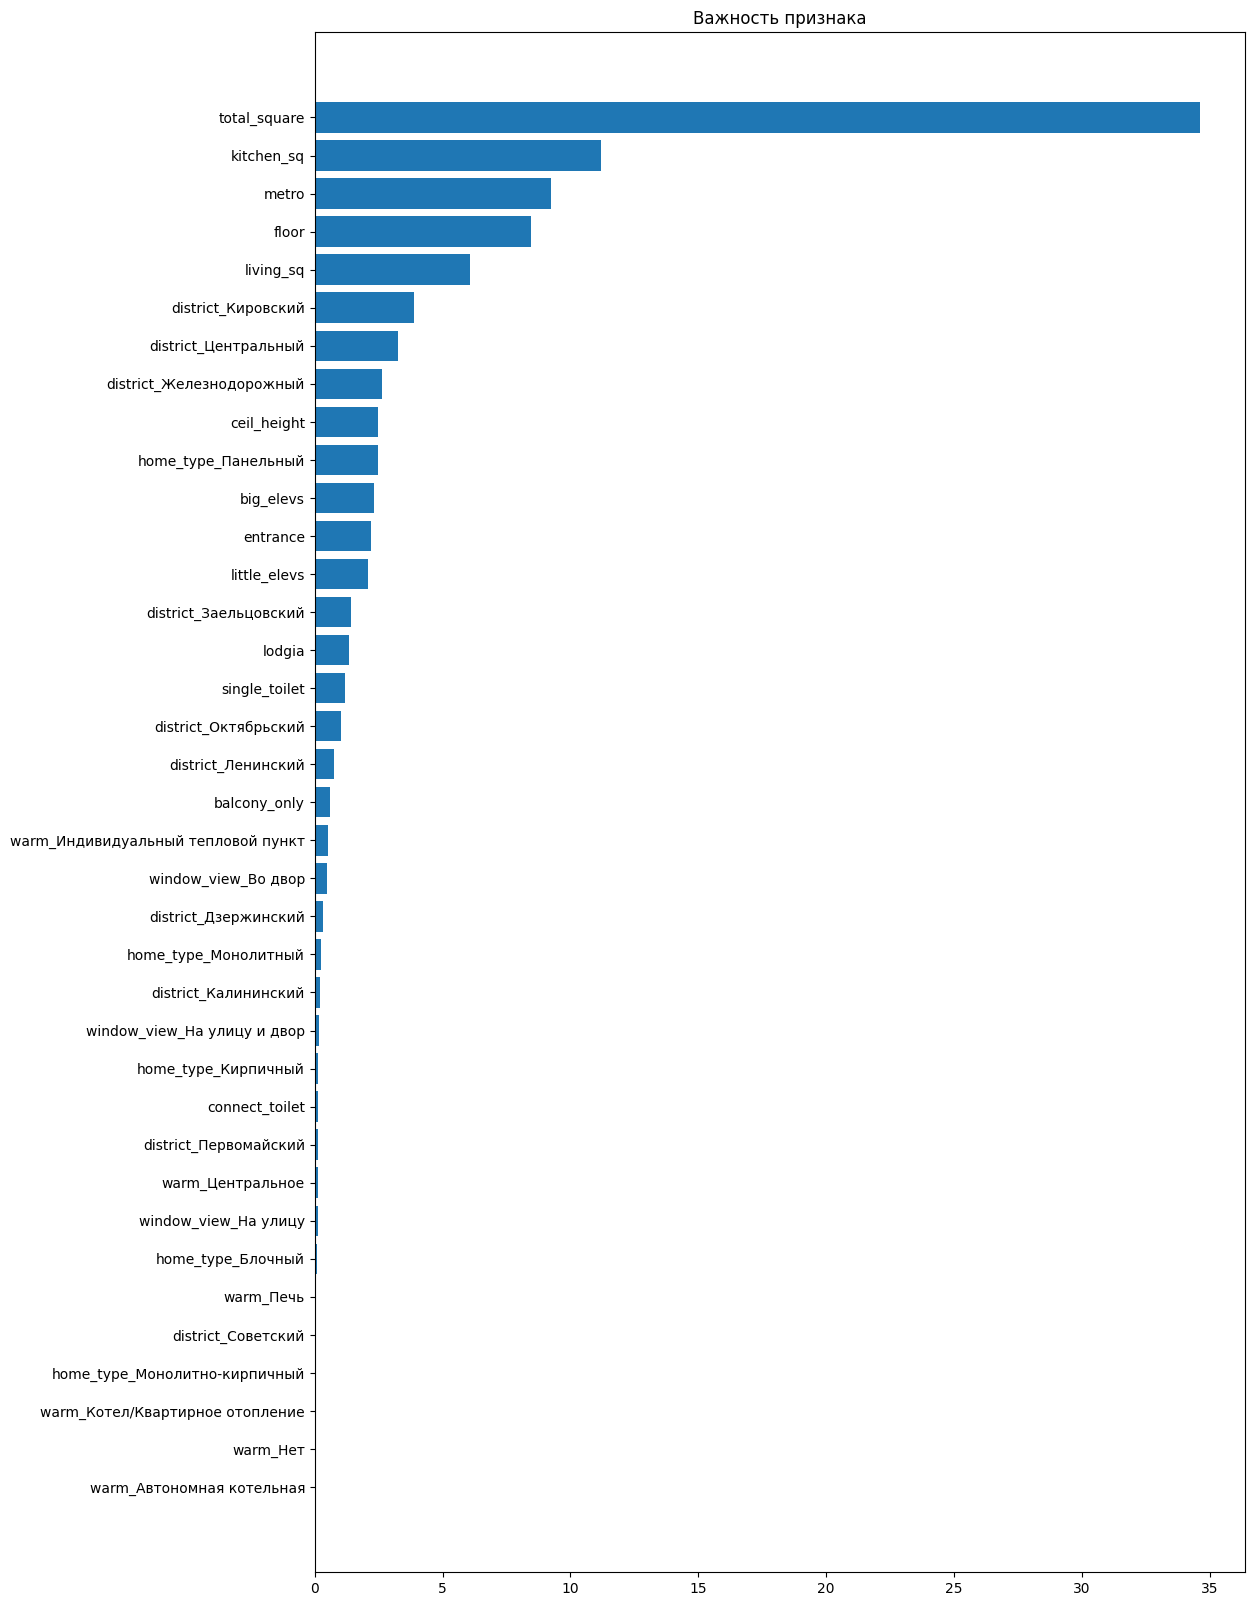

In [412]:
feature_importance = model_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Важность признака')

Провалидируем модели в разрезе различных ценовых категорий. Помимо линейной регрессии, случайного леса и градиентного бустинга посмотрим на модель гребневой регрессии и лассо регрессии.

In [418]:
# evaluating models
df_mae = pd.DataFrame({})
df_mape = pd.DataFrame({})
df_mse = pd.DataFrame({})

groups = [(1000000, 2000000), (2000000, 3000000), (3000000, 4000000), (4000000, 5000000), (5000000, 6000000), (6000000, 7000000), (7000000, float('inf'))]

print('Случайный лес: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_rf.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Случайный лес: 
1000000 рублей - 2000000 рублей
MAE: 693340.8136449307
MAPE: 41.27360334459561 %
MSE: 734290055407.4751

2000000 рублей - 3000000 рублей
MAE: 386907.6968907073
MAPE: 14.818612745872075 %
MSE: 280536580235.5866

3000000 рублей - 4000000 рублей
MAE: 371963.30483639974
MAPE: 11.073066068684579 %
MSE: 259248717277.23492

4000000 рублей - 5000000 рублей
MAE: 655927.0602227264
MAPE: 14.306001684716902 %
MSE: 644394468608.4982

5000000 рублей - 6000000 рублей
MAE: 712657.0551995491
MAPE: 12.798975684423242 %
MSE: 898214347924.2374

6000000 рублей - 7000000 рублей
MAE: 1025336.0373810347
MAPE: 15.595113409016955 %
MSE: 1459531378330.5876

7000000 рублей - inf рублей
MAE: 1821685.29753287
MAPE: 18.25243692016532 %
MSE: 6740480735994.678



In [414]:
print('Градиентный бустинг: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_gb.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Градиентный бустинг: 
1000000 рублей - 2000000 рублей
MAE: 434692.0681588035
MAPE: 26.094697309917553 %
MSE: 585223988304.2448

2000000 рублей - 3000000 рублей
MAE: 311178.11066069547
MAPE: 11.715213722853978 %
MSE: 179344248155.0311

3000000 рублей - 4000000 рублей
MAE: 387023.91972981597
MAPE: 11.512926349718839 %
MSE: 229208877162.34064

4000000 рублей - 5000000 рублей
MAE: 537977.7833142623
MAPE: 11.884807853568411 %
MSE: 544024772747.9064

5000000 рублей - 6000000 рублей
MAE: 673776.4988606063
MAPE: 12.065479866630362 %
MSE: 996833470488.5027

6000000 рублей - 7000000 рублей
MAE: 952151.2610600487
MAPE: 14.484067448839918 %
MSE: 1460323620180.7507

7000000 рублей - inf рублей
MAE: 1436294.6355277926
MAPE: 14.829965931041034 %
MSE: 4064301776682.835



In [415]:
print('Линейная регрессия: ')
model = LinearRegression()
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Линейная регрессия: 
1000000 рублей - 2000000 рублей
MAE: 472189.49204207625
MAPE: 27.32348113646687 %
MSE: 521617173507.90796

2000000 рублей - 3000000 рублей
MAE: 522141.70124883053
MAPE: 19.816052029402965 %
MSE: 509452253224.8271

3000000 рублей - 4000000 рублей
MAE: 548741.1967400631
MAPE: 16.364702254343165 %
MSE: 456574811354.0185

4000000 рублей - 5000000 рублей
MAE: 621744.1574090491
MAPE: 13.819724636987301 %
MSE: 642828514138.266

5000000 рублей - 6000000 рублей
MAE: 661196.1485369548
MAPE: 11.87745546492138 %
MSE: 821239578933.6747

6000000 рублей - 7000000 рублей
MAE: 985795.0387086069
MAPE: 14.951074025868285 %
MSE: 1520109694860.5286

7000000 рублей - inf рублей
MAE: 1734885.9875519872
MAPE: 16.946838829992306 %
MSE: 6665543668657.886



In [416]:
print('Гребневая регрессия: ')

model = Ridge(random_state=42)
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Гребневая регрессия: 
1000000 рублей - 2000000 рублей
MAE: 494694.3605608842
MAPE: 28.839117269092412 %
MSE: 533131472988.4597

2000000 рублей - 3000000 рублей
MAE: 523396.9545208865
MAPE: 19.86287727246896 %
MSE: 511439383011.577

3000000 рублей - 4000000 рублей
MAE: 548575.9243177806
MAPE: 16.362140949435947 %
MSE: 455540647526.96094

4000000 рублей - 5000000 рублей
MAE: 622417.7266225412
MAPE: 13.83470768251839 %
MSE: 641248859392.1489

5000000 рублей - 6000000 рублей
MAE: 660780.1996417894
MAPE: 11.867760678980856 %
MSE: 820827307251.6753

6000000 рублей - 7000000 рублей
MAE: 986470.7987526552
MAPE: 14.96219274396848 %
MSE: 1521163669963.3796

7000000 рублей - inf рублей
MAE: 1734974.4411904786
MAPE: 16.945530773774525 %
MSE: 6651581021245.043



In [417]:
print('Лассо регрессия: ')

model = Lasso(random_state=42)
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Лассо регрессия: 
1000000 рублей - 2000000 рублей
MAE: 472225.3138633478
MAPE: 27.325931059590474 %
MSE: 521617766317.7595

2000000 рублей - 3000000 рублей
MAE: 522142.61888223846
MAPE: 19.816100298544157 %
MSE: 509457484419.3865

3000000 рублей - 4000000 рублей
MAE: 548740.1685681314
MAPE: 16.364672212765463 %
MSE: 456570635749.5774

4000000 рублей - 5000000 рублей
MAE: 621747.3820901966
MAPE: 13.819799123393597 %
MSE: 642826125038.5182

5000000 рублей - 6000000 рублей
MAE: 661190.3902699079
MAPE: 11.877346228847847 %
MSE: 821231315178.1659

6000000 рублей - 7000000 рублей
MAE: 985795.9122923133
MAPE: 14.951087333343924 %
MSE: 1520111513507.722

7000000 рублей - inf рублей
MAE: 1734874.7913022698
MAPE: 16.946766964050028 %
MSE: 6665329518920.416



c:\Users\eliza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.801e+14, tolerance: 1.013e+12
  model = cd_fast.enet_coordinate_descent(


Можем видеть, что все модели плохо предсказывают цену "дешевых" квартир. В диапазоне от 3 миллионов до 5 миллионов лучше всех себя показывает градиентный бустинг, а цену "дорогих" квартир все модели предсказывают не очень хорошо, но значения ошибок не сильно различаются у моделей. Можно сделать вывод, что необходимо дополнить выборку квартирами с низкой ценой и высокой ценой, чтобы улучшить метрики качества моделей.